In [1]:
"""
Equation: u_{xx} + u_{yy} + 2 * pi * pi * sin(pi * x) * sin(pi * y) = 0
0 < x, y < 1
BC: u(0, y) = u(x, 0) = u(x, 1) = u(1, y) = 0

Solution: u = sin(pi * x) * sin(pi * y)


- Reference code: https://github.com/jayroxis/PINNs/blob/master/Burgers%20Equation/Burgers.ipynb
- The equation is based on the PHASM example: 
https://github.com/nathanwbrei/phasm/blob/main/examples/pde_solver/diffusion_pde_solver.cpp
"""

import math

import torch
import torch.nn as nn
import numpy as np
from collections import OrderedDict

In [2]:
class NN(nn.Module):
    '''
    This part is the same as the reference.
    '''
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        depth,
        act=torch.nn.Tanh,
    ):
        super(NN, self).__init__()
        
        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', act()))
        for i in range(depth): 
            layers.append(
                ('hidden_%d' % i, torch.nn.Linear(hidden_size, hidden_size))
            )
            layers.append(('activation_%d' % i, act()))
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))

        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

In [3]:
N = 64


class Net:
    '''
    This part is revised based on the reference.
    '''
    def __init__(self, num_hidden_depth:int=4, num_hidden_size:int=20):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN(
            input_size=2,
            hidden_size=num_hidden_size,
            output_size=1,
            depth=num_hidden_depth,
            act=torch.nn.Tanh
        ).to(device)
        
        self.h = 1/N
        x = torch.arange(0, 1 + self.h, self.h)
        y = torch.arange(0, 1 + self.h, self.h)

        # exact solution
        self.X = torch.stack(torch.meshgrid(x, y)).reshape(2, -1).T
        
        # training data
        bc_left = torch.stack(torch.meshgrid(x[0], y)).reshape(2, -1).T
        bc_right = torch.stack(torch.meshgrid(x[-1], y)).reshape(2, -1).T
        bc_down = torch.stack(torch.meshgrid(x, y[0])).reshape(2, -1).T
        bc_top = torch.stack(torch.meshgrid(x, y[-1])).reshape(2, -1).T
        self.X_train = torch.cat([bc_left, bc_right, bc_down, bc_top])
        
        y_bc_left = torch.zeros(len(bc_left))
        y_bc_right = torch.zeros(len(bc_right))
        y_bc_down = torch.zeros(len(bc_down))
        y_bc_top = torch.zeros(len(bc_top))
        self.y_train = torch.cat([y_bc_left, y_bc_right, y_bc_down, y_bc_top])
        self.y_train = self.y_train.unsqueeze(1)
        
        self.X = self.X.to(device)
        self.X_train = self.X_train.to(device)
        self.y_train = self.y_train.to(device)
        self.X.requires_grad = True
#         print(f"self.X_train.shape: {self.X_train.shape}")
#         print(f"self.y_train.shape: {self.y_train.shape}")
#         print(f"self.X.shape: {self.X.shape}")
        
        self.criterion = torch.nn.MSELoss()
        self.iter = 1
        
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps
        )
        
        self.adam = torch.optim.Adam(self.model.parameters())
        
    def loss_func(self):
        self.optimizer.zero_grad()
        
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)

        u = self.model(self.X)

        #! Not farmilar with grad part. Seems it's correct based on the result.
        # torch.autograd.grad(outputs, inputs, grad_outputs=None, retain_graph=None, create_graph=False, only_inputs=True, allow_unused=False, is_grads_batched=False)
        du_dX = torch.autograd.grad(u, self.X, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True, allow_unused=True)[0]
        du_dx = du_dX[:, 0]
        du_dy = du_dX[:, 1]
#         print(du_dX.shape, du_dx.shape, du_dy.shape)
        du_dxx = torch.autograd.grad(du_dx, self.X, grad_outputs=torch.ones_like(du_dx), retain_graph=True, create_graph=True, allow_unused=True)[0][:, 0]
        du_dyy = torch.autograd.grad(du_dy, self.X, grad_outputs=torch.ones_like(du_dy), retain_graph=True, create_graph=True, allow_unused=True)[0][:, 1]
#         print(du_dxx.shape, du_dyy.shape)
        loss_pde = self.criterion(du_dxx + du_dyy, -2.0 * math.pi * math.pi * torch.sin(math.pi * self.X[:, 0]) * torch.sin(math.pi * self.X[:, 1]))

        loss = loss_pde + loss_data
        loss.backward()
        if self.iter % 100 == 0: 
            print(f"iter={self.iter}, loss={loss.item()}")
        self.iter = self.iter + 1
        return loss
    
    def train(self):
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

In [4]:
# Training

net = Net(4, 20)
print(net.model)

NN(
  (layers): Sequential(
    (input): Linear(in_features=2, out_features=20, bias=True)
    (input_activation): Tanh()
    (hidden_0): Linear(in_features=20, out_features=20, bias=True)
    (activation_0): Tanh()
    (hidden_1): Linear(in_features=20, out_features=20, bias=True)
    (activation_1): Tanh()
    (hidden_2): Linear(in_features=20, out_features=20, bias=True)
    (activation_2): Tanh()
    (hidden_3): Linear(in_features=20, out_features=20, bias=True)
    (activation_3): Tanh()
    (output): Linear(in_features=20, out_features=1, bias=True)
  )
)


/Users/xinxinmei/opt/anaconda3/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1656352388419/work/aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
net.train()

iter=100, loss=10.249832153320312
iter=200, loss=7.884663105010986
iter=300, loss=6.507655143737793
iter=400, loss=0.6626932621002197
iter=500, loss=0.20493900775909424
iter=600, loss=0.12475463002920151
iter=700, loss=0.10650968551635742
iter=800, loss=0.09621208906173706
iter=900, loss=0.08808056265115738
iter=1000, loss=0.08087816089391708
iter=1100, loss=0.016340669244527817
iter=1200, loss=0.008846581913530827
iter=1300, loss=0.005286121740937233
iter=1400, loss=0.0031151867005974054
iter=1500, loss=0.002103890059515834
iter=1600, loss=0.0007869809051044285
iter=1700, loss=0.000297823513392359
iter=1800, loss=0.00020490624592639506
iter=1900, loss=0.0001401862973580137
iter=2000, loss=0.00011072537745349109
iter=2100, loss=8.64532048581168e-05
iter=2200, loss=6.639808270847425e-05
iter=2300, loss=6.011010555084795e-05
iter=2400, loss=5.502052590600215e-05
iter=2500, loss=4.3955198634648696e-05
iter=2600, loss=3.876614209730178e-05
iter=2700, loss=2.61748609773349e-05
iter=2800, lo

In [6]:
# Evaluation
h = 1 / N
x = torch.arange(0, 1 + h, h)
y = torch.arange(0, 1 + h, h)

# exact solution
X = torch.stack(torch.meshgrid(x, y)).reshape(2, -1).T
X = X.to(net.X.device)

model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X).reshape(len(x), len(y))
    
print(y_pred.max())

tensor(1.0000)


<AxesSubplot:>

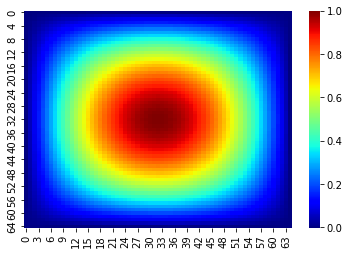

In [7]:
import seaborn as sns
sns.heatmap(y_pred, cmap='jet')

In [8]:
# Solution: u = sin(pi * x) * sin(pi * y)
y_real = torch.sin(math.pi * X[:, 0]) * torch.sin(math.pi * X[:, 1])
y_real = y_real.reshape(len(x), len(y))

<AxesSubplot:>

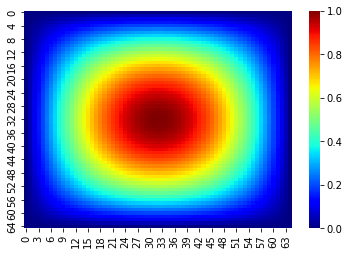

In [9]:
sns.heatmap(y_real, cmap='jet')

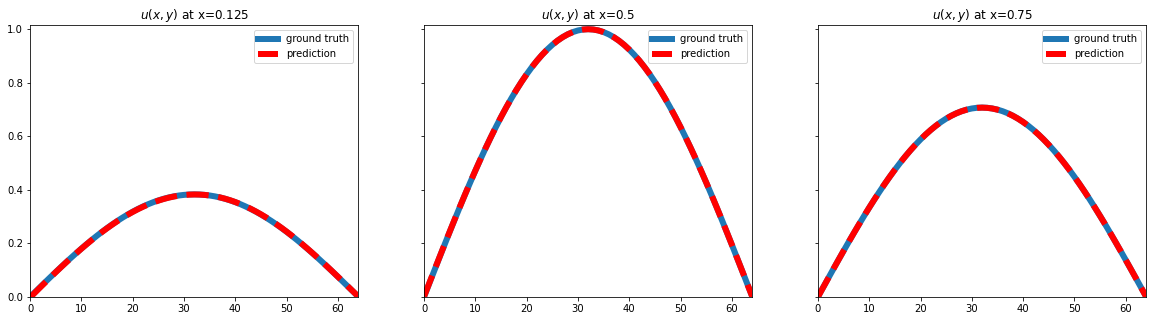

In [10]:
from matplotlib import pyplot as plt
import matplotlib

fig, axs = plt.subplots(1,3, sharey=True, figsize=(20,5))
width = 6

for i, x in enumerate([0.125, 0.5, 0.75]):
    x_idx = int(N * x)
    
    axs[i].set_title(f"$u(x, y)$ at x={x}")
    axs[i].set_xlim(0, N)
    axs[i].set_ylim(0, 1 + 1/N)
    axs[i].plot(y_real[x_idx, :],  linewidth=width, label="ground truth")
    axs[i].plot(y_pred[x_idx, :], "r--", linewidth=width, label='prediction')
    axs[i].legend(loc='upper right')